## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

I acknowledge that I have used AI to the extent permitted by the UVA AI acceptable use policy. I acknowlegde that I am aware of the possibility of AI producing errors and offensive content and certify that I have taken the necessary measures to ensure that the work produced is both accurate and ethical to the best of my ability.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [29]:
import pickle
with open('/content/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
# I changed the directory slightly so that the code would run. Since I downloaded
# the files locally, the given code needed to be tweaked slightly so that the code
# would run.
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

In [30]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

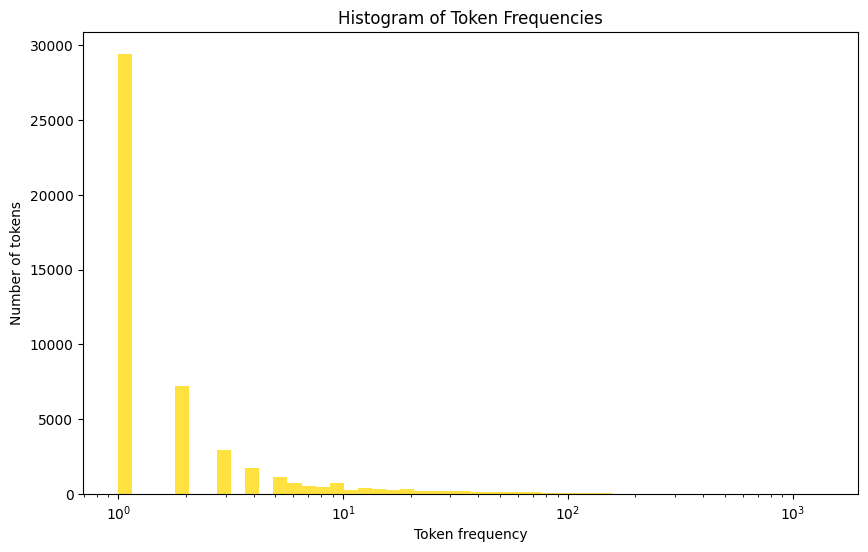

In [31]:
with open('/content/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

token_series = pd.Series(all_tokens)

token_freq = token_series.value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(token_freq, bins=50, log_scale=True, color='gold', edgecolor=None)
plt.title("Histogram of Token Frequencies")
plt.xlabel("Token frequency")
plt.ylabel("Number of tokens")
plt.show()


Overall, there's a gradual decrease in the number of tokens as the Token frequency increases. Token frequency at 10^0 is the highest level, followed by a drastic decreased between 10^0 to 10^1. Each subsequent frequency decreases at a rate generally equal to that of the logarithmic scale.

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [32]:
emails = pd.read_parquet('/content/Phishing_clean.parquet')

X = emails.drop(columns=['Email Type'])
y = emails['Email Type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Training R-squared: {r2_train:.4f}")
print(f"Test R-squared: {r2_test:.4f}")

coefficients = pd.Series(model.coef_, index=X.columns)

top_words = coefficients.abs().sort_values(ascending=False).head(15)
print("\nTop 15 tokens most strongly influencing predictions:")
print(coefficients.loc[top_words.index])


Training R-squared: 0.7670
Test R-squared: 0.6659

Top 15 tokens most strongly influencing predictions:
intervention        -1.259257
localized            0.824350
thermal              0.747006
crawler              0.696167
background-image:   -0.622909
helvetica,           0.598560
aging                0.594956
form.                0.576886
gray;               -0.574480
a:active             0.574480
retrieving          -0.573761
zdnet               -0.560954
{text-decoration:    0.497075
xanaax               0.491981
transcript           0.488978
dtype: float64


As our code produced, the R-squared value of the test set was 0.6659 while the training set's R-squared value was 0.7670. It appears that the word with the greatest absolute value is "intervention" at -1.259257. This means that it has the greatest weight of all words in determining what type of email it will be used in. However, since its value is negative, the word has a stronger correlation with an email being legitimate (0) instead of a phishing email (1). Other words with large absolute coefficient values include "localized" (0.824350), "thermal" (0.747006), "crawler" (0.696167), and "background-image:" (-0.622909). The next three words after "intervention" have positive values, meaning that they have a relatively heavy weight in determining that the emails they are included in will be phising.

### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

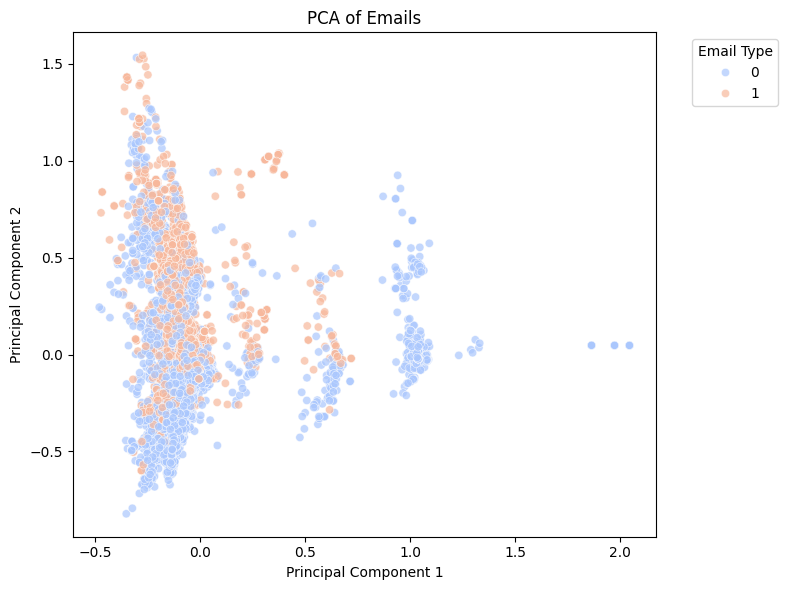

In [25]:
X = emails.drop(columns=['Email Type'])
y = emails['Email Type']

pca_model = PCA(n_components=2)
X_pca = pca_model.fit_transform(X)

pca = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Email Type': y
})

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca,
    x='PC1', y='PC2',
    hue='Email Type',
    palette='coolwarm',
    alpha=0.7
)
plt.title('PCA of Emails')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Email Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Between the Principle Component 1 (PC1) ranges of -0.5 and 0, we see a relatively even distribution of Principle Component 2 (PC2) points. Across the next 3 intervals of equal length (0.5) across PC1 (that is, 0-0.5, 0.5-1, 1-1.5), we see sparse flickerings of data in a similar yet much smaller shape. Additionally, the phishing (red) and non-phishing (blue) are fairly intermingled, showing that it's somewhat difficult to predict whether an email is spam based on the indicator tokens (words) present. That said, there is some consistency in terms of how the phishing and non-spam emails are clustered. In the greatest cluster between -0.5-0 PC1, the spam emails are largely concentrated around themselves, so while closely related to each other, there is usually a distinct "line" between spam and non-spam, meaning that a well trained model could theoretically pick out spam from non-spam with relative certainty.

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [24]:
X = emails.drop(columns=['Email Type'])
y = emails['Email Type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pca = PCA(n_components=2610, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

model = LinearRegression()
model.fit(X_train_pca, y_train)

y_train_pred = model.predict(X_train_pca)
y_test_pred = model.predict(X_test_pca)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R-squared on Training Set: {r2_train:.4f}")
print(f"R-squared on Test Set: {r2_test:.4f}")


R-squared on Training Set: 0.7662
R-squared on Test Set: 0.6683


As calculated, the R-squared values for the test and training sets are 0.6683 and 0.7662, respectively. Compared to the test and training R-squared values for the linear regression model (0.6659 and 0.7670, respectively). These are very nearly equal, showing that both yield a comparable level of certainty and reliability on either method's ability to train a model seeking to distinguish spam from non-spam.

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Basically, the advantage to using PCA to run high-dimension regression instead of original data is to optimize and condense complex, multi-dimensional data. Using PCA, we're able to compress numerous variables down to a more basic dimensionality which enables us to create a regression model that returns more precise predictions that are more resilient and less affected by noise since we're simplifying the structure (flattening the dimensionality). In doing so, we're also able to make our computations more efficient, as trainihg a model post-PCA on less complex data than before eases the process.